In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [2]:
!nvidia-smi

Wed Feb 17 11:35:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

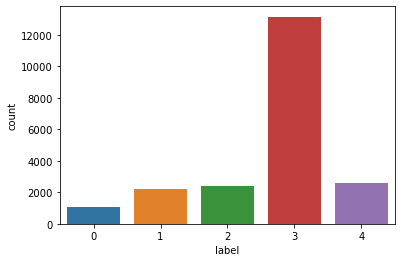

In [5]:
sns.countplot(train['label'])

In [6]:
train['label'] = train['label'].astype(str) #we are converting the label column into string as we will be using this to feed into the ImageDataGenerator

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  object
dtypes: object(2)
memory usage: 334.5+ KB


In [8]:
json = pd.read_json('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json',typ = 'series')

In [9]:
json

0         Cassava Bacterial Blight (CBB)
1    Cassava Brown Streak Disease (CBSD)
2             Cassava Green Mottle (CGM)
3           Cassava Mosaic Disease (CMD)
4                                Healthy
dtype: object

In [10]:
IMG_SIZE = 256

In [11]:
train_datagen = image.ImageDataGenerator(rotation_range = 180,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  brightness_range = [0.1,1.1],
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  rescale = 1./255,
                                  zoom_range = 0.5,
                                  validation_split = 0.2)
val_datagen = image.ImageDataGenerator(rescale=1./255,
                                      validation_split = 0.2)

In [12]:
train_generator = train_datagen.flow_from_dataframe(dataframe = train,
                                                   directory = "/kaggle/input/cassava-leaf-disease-classification/train_images",
                                                   x_col = 'image_id',
                                                   y_col = 'label',
                                                   target_size = (IMG_SIZE,IMG_SIZE),
                                                   color_mode = "rgb",
                                                   class_mode = "categorical",
                                                   batch_size = 64,
                                                   shuffle = True,
                                                   subset = 'training')

val_generator = val_datagen.flow_from_dataframe(dataframe = train,
                                                   directory = "/kaggle/input/cassava-leaf-disease-classification/train_images",
                                                   x_col = 'image_id',
                                                   y_col = 'label',
                                                   target_size = (IMG_SIZE,IMG_SIZE),
                                                   color_mode = "rgb",
                                                   class_mode = "categorical",
                                                   batch_size = 64,
                                                   shuffle = True,
                                                   subset = 'validation')

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'Same',input_shape = [IMG_SIZE,IMG_SIZE,3]),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3,3), activation = 'relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024,activation = 'relu'),
    tf.keras.layers.Dense(5, activation = 'softmax')
])

In [14]:
from tensorflow.keras.optimizers import RMSprop,Adam
optimizer = Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
             metrics = ['accuracy'])

In [15]:
epochs = 10
batch_size = 64

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       1

In [17]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

In [18]:
history = model.fit_generator(train_generator,epochs = epochs,validation_data = val_generator,callbacks = early_stop)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
268/268 [==============================] - 525s 2s/step - loss: 1.3065 - accuracy: 0.5929 - val_loss: 1.0929 - val_accuracy: 0.6287
Epoch 2/10
268/268 [==============================] - 441s 2s/step - loss: 1.1018 - accuracy: 0.6215 - val_loss: 1.0054 - val_accuracy: 0.6380
Epoch 3/10
268/268 [==============================] - 442s 2s/step - loss: 1.0677 - accuracy: 0.6253 - val_loss: 1.0046 - val_accuracy: 0.6371
Epoch 4/10
268/268 [==============================] - 441s 2s/step - loss: 1.0396 - accuracy: 0.6294 - val_loss: 0.9758 - val_accuracy: 0.6459
Epoch 5/10
268/268 [==============================] - 444s 2s/step - loss: 1.0212 - accuracy: 0.6348 - val_loss: 0.9599 - val_accuracy: 0.6581
Epoch 6/10
268/268 [==============================] - 440s 2s/step - loss: 0.9578 - accuracy: 0.6539 - val_loss: 0.9129 - val_accuracy: 0.6637
Epoch 7/10
268/268 [==============================] - 439s 2s/step - loss: 0.9162 - accuracy: 0.6643 - val_loss: 0.8492 - val_accuracy: 0.6747

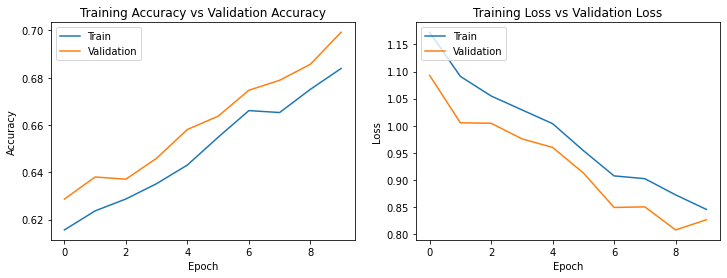

In [19]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [21]:
model.save('Model1.h5')

In [22]:
preds = []
ss = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv') #not written by me

for image in ss.image_id:
    img = tf.keras.preprocessing.image.load_img('../input/cassava-leaf-disease-classification/test_images/' + image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.reshape(img, (-1, IMG_SIZE, IMG_SIZE, 3))
    prediction = model.predict(img/255)
    preds.append(np.argmax(prediction))

submission = pd.DataFrame({'image_id': ss.image_id, 'label': preds})
submission

,image_id,label
0,2216849948.jpg,3


In [ ]:
submission.to_csv('submission.csv', index = False)